**Note: The "scales_to_keep" variable is used to filter the dataset based on specific scale ranges. During model training, it was assigned sequentially and correctly. However, for prediction, we intentionally used different scale ranges (e.g., "-1", "1, 2", "3, 4", "5, 6") to load images of varying scales conveniently and test the model's performance across these ranges. This variation is intentional and part of our methodology to evaluate the model effectively.**

## Orginal data accrose 3 clacess


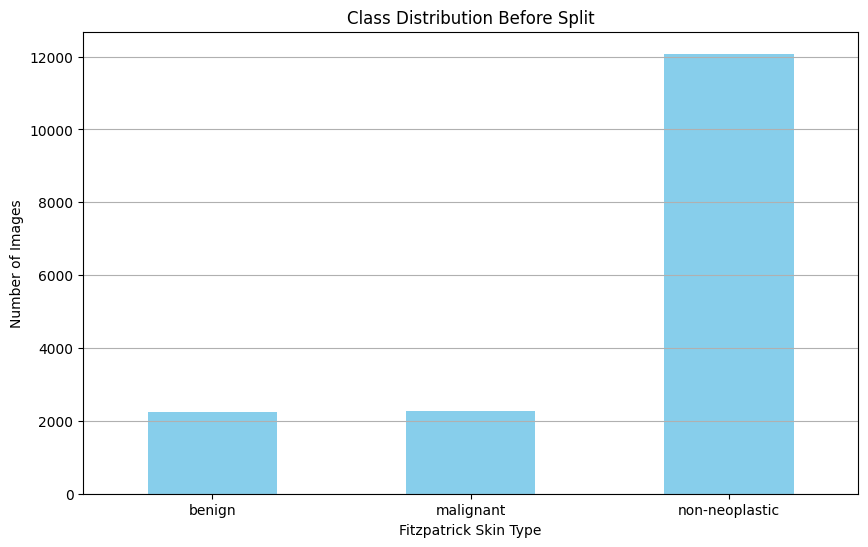

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_cleaned = pd.read_csv('/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/fitzpatrick17k.csv')
skin_type_counts = df_cleaned['three_partition_label'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
skin_type_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution Before Split')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(len(skin_type_counts.index)), labels=skin_type_counts.index, rotation=0)
plt.grid(axis='y')
plt.show()


In [ ]:
df_cleaned['three_partition_label'].value_counts().sort_index()

three_partition_label
benign             2234
malignant          2263
non-neoplastic    12080
Name: count, dtype: int64

## Skin Tone 1+2 Light Shade

### Load our pre processed data easily keep only 1, 2 skin tone

In [ ]:
import pandas as pd
import os
from zipfile import ZipFile

# Define file paths
zip_file_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/all_images_trainAug_testNonAuh_V3_withSToneDF.zip'
unzip_dir = '/content/all_images'
metadata_csv_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/image_metadata_trainAug_testNonAuh_V3_withSToneDF.csv'

# Unzip the images folder (run only if not already unzipped)
if not os.path.exists(unzip_dir):
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print(f"Images unzipped to {unzip_dir}")

# Load the metadata DataFrame
df_all_images = pd.read_csv(metadata_csv_path)

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train']
df_test = df_all_images[df_all_images['set'] == 'test']

# Function to load images dynamically based on class label
def get_class_data(df, class_label):
    if class_label in df['three_partition_label'].values:
        class_data = df[df['three_partition_label'] == class_label]
        X = class_data['resized_image_path'].values
        y = class_data['three_partition_label'].values
        return X, y
    else:
        print(f"Class '{class_label}' not found in DataFrame.")
        return None, None

# Example: Load image paths and labels for 'malignant' class from train set
X_train_malignant, y_train_malignant = get_class_data(df_train, 'malignant')

# Example: Load image paths and labels for 'non-neoplastic' class from test set
X_test_non_neoplastic, y_test_non_neoplastic = get_class_data(df_test, 'non-neoplastic')

# Display counts
print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Verify the loaded data
print(df_test.head())
df_train.head()

Train set class distribution:
three_partition_label
benign            9719
non-neoplastic    9664
malignant         9574
Name: count, dtype: int64

Test set class distribution:
three_partition_label
non-neoplastic    2416
malignant          453
benign             447
Name: count, dtype: int64
                                      resized_image_path  \
13261  /content/all_images/b6f9c924bb3b864c03ecfad295...   
13262  /content/all_images/3e96f0e6bdf82fe4ee5d7635c7...   
13263  /content/all_images/abf70b58e93e881fdad4566809...   
13264  /content/all_images/e789130a814619c1773eef8643...   
13265  /content/all_images/60c20c7458e1a508b96bd1dec2...   

      three_partition_label   set  fitzpatrick_scale  
13261        non-neoplastic  test                  6  
13262                benign  test                  1  
13263                benign  test                  1  
13264             malignant  test                  6  
13265             malignant  test                  2  


resized_image_path three_partition_label  \
0  /content/all_images/96e320998184af49bfc791c8f1...             malignant   
1  /content/all_images/3b76144cda29793ac4bb709ab4...        non-neoplastic   
2  /content/all_images/da81b0441ab66a8c3f55489a0d...             malignant   
3  /content/all_images/72430e826363a44a2f9d5dd7e8...             malignant   
4  /content/all_images/860590217a382b642fe9755f80...        non-neoplastic   

     set  fitzpatrick_scale  
0  train                  3  
1  train                  2  
2  train                  1  
3  train                  4  
4  train                  3

<Figure size 1000x600 with 0 Axes>

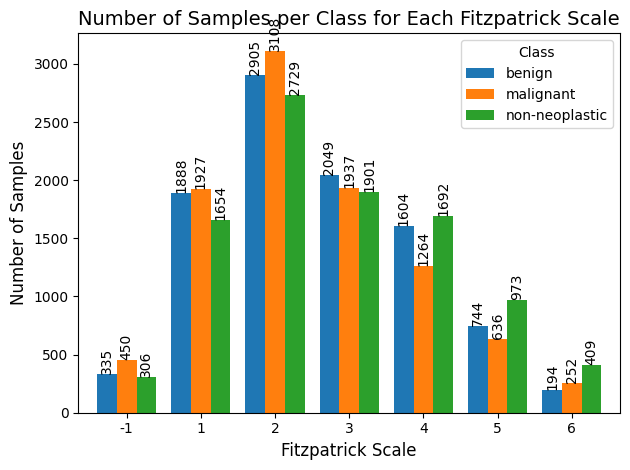

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'fitzpatrick_scale' and 'label', and count the number of samples
scale_class_counts = df_train.groupby(['fitzpatrick_scale', 'three_partition_label']).size().unstack(fill_value=0)

# Create the grouped bar chart
plt.figure(figsize=(10, 6))
ax = scale_class_counts.plot(kind='bar', stacked=False, width=0.8)

# Add labels and title
plt.title('Number of Samples per Class for Each Fitzpatrick Scale', fontsize=14)
plt.xlabel('Fitzpatrick Scale', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Class', loc='upper right')

# Display count values above each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load your data and initialize the LabelEncoder
df_all_images = pd.read_csv(metadata_csv_path)

# Initialize LabelEncoder
label_encoder = LabelEncoder()
df_all_images['three_partition_label'] = label_encoder.fit_transform(df_all_images['three_partition_label'])

# Print the class mapping
print("Class mapping:")
for index, class_label in enumerate(label_encoder.classes_):
    print(f"{index}: {class_label}")

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train'].copy()
df_test = df_all_images[df_all_images['set'] == 'test'].copy()
# df_test = df_test

# Apply filtering for specific scales in train and test sets
scales_to_keep = [-1]
df_train = df_train[df_train['fitzpatrick_scale'].isin(scales_to_keep)].copy()
df_test = df_test[df_test['fitzpatrick_scale'].isin(scales_to_keep)].copy()


print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Convert labels to string type for `class_mode='sparse'`
df_train['three_partition_label'] = df_train['three_partition_label'].astype(str)
df_test['three_partition_label'] = df_test['three_partition_label'].astype(str)

# Split df_train into training and validation sets
# df_test, df_val = train_test_split(df_test, test_size=0.50, stratify=df_test['three_partition_label'], random_state=42)

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    # dataframe=df_val,
    dataframe=df_test,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Class mapping:
0: benign
1: malignant
2: non-neoplastic
Train set class distribution:
three_partition_label
1    450
0    335
2    306
Name: count, dtype: int64

Test set class distribution:
three_partition_label
2    82
1    18
0    13
Name: count, dtype: int64
Found 1091 validated image filenames belonging to 3 classes.
Found 113 validated image filenames belonging to 3 classes.
Found 113 validated image filenames belonging to 3 classes.


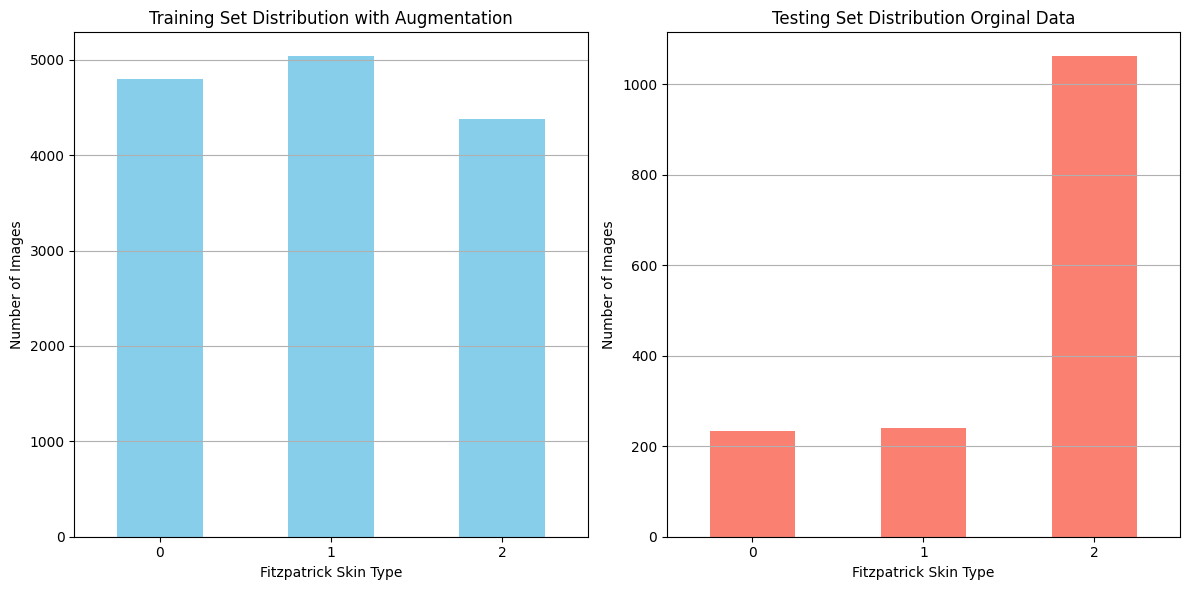

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

train_skin_type_counts = df_train['three_partition_label'].value_counts().sort_index()
test_skin_type_counts = df_test['three_partition_label'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_skin_type_counts.plot(kind='bar', color='skyblue')
plt.title('Training Set Distribution with Augmentation')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(len(train_skin_type_counts.index)), labels=train_skin_type_counts.index, rotation=0)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
test_skin_type_counts.plot(kind='bar', color='salmon')
plt.title('Testing Set Distribution Orginal Data')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(len(test_skin_type_counts.index)), labels=test_skin_type_counts.index, rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


#### See Last 20 train Image to be sure all goes well

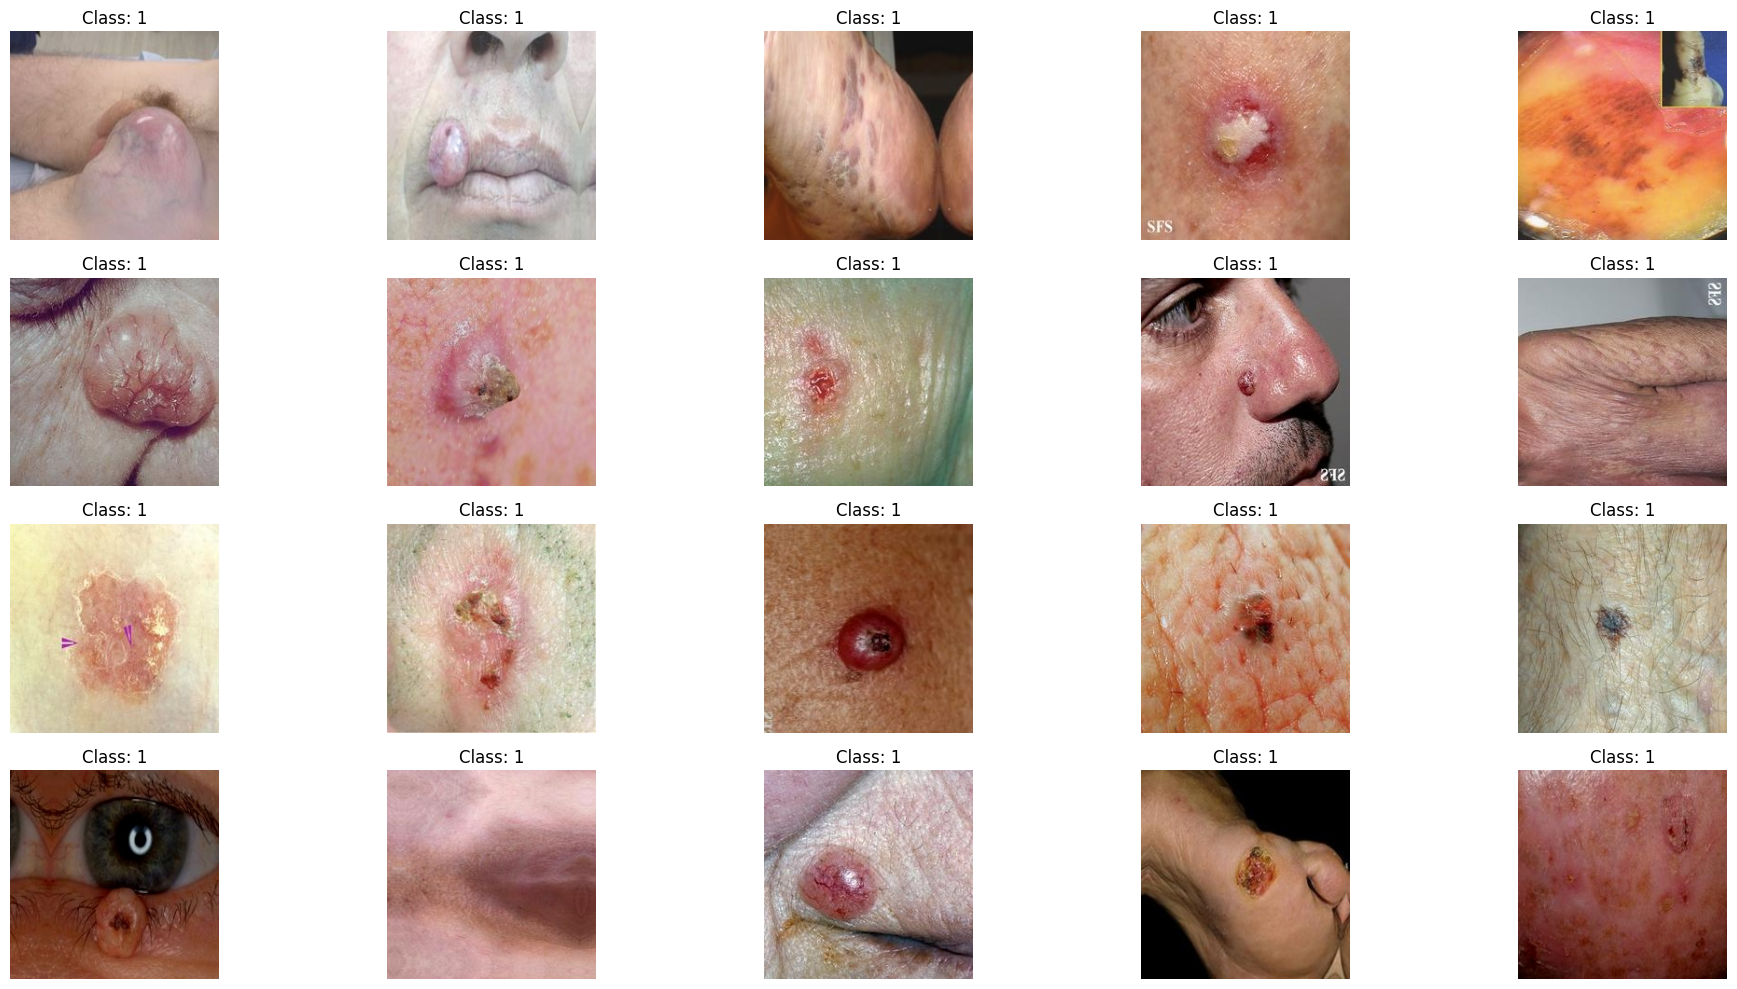

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Display the first 20 augmented images
sample = df_train.tail(20)

plt.figure(figsize=(20, 10))

for i, row in enumerate(sample.itertuples(), start=1):
    image_path = row.resized_image_path
    image = Image.open(image_path)

    plt.subplot(4, 5, i)
    plt.imshow(image)
    plt.title(f"Class: {row.three_partition_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### EfficientnetB0


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau
import numpy as np

# Load the EfficientNetB0 model with ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 units
x = BatchNormalization()(x)  # Batch normalization for stability
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
predictions = Dense(3, activation='softmax')(x)  # Output layer for 3 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze the base model layers to train only the custom layers
for layer in base_model.layers:
    layer.trainable = False

csv_logger = CSVLogger('training_log.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# # Define custom class weights to improve recall for underperforming classes
# # Adjust these weights to balance the classes better
custom_class_weights = {
    0: 2.0,  # Higher weight for class 0 (benign)
    1: 3.0,  # Higher weight for class 1 (malignant)
    2: 1.0   # Lower weight for class 2 (non-neoplastic) since its recall is already good
}

# print("Custom Class Weights:", custom_class_weights)

# # Compile the model with custom class weights
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model using custom class weights
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=custom_class_weights,
    callbacks=[csv_logger, early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.4864 - loss: 2.8044 - val_accuracy: 0.4531 - val_loss: 1.1995 - learning_rate: 1.0000e-04
Epoch 2/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 53s 90ms/step - accuracy: 0.6332 - loss: 1.6833 - val_accuracy: 0.5046 - val_loss: 1.2148 - learning_rate: 1.0000e-04
Epoch 3/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.6732 - loss: 1.4112 - val_accuracy: 0.5625 - val_loss: 1.1450 - learning_rate: 1.0000e-04
Epoch 4/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.7129 - loss: 1.1980 - val_accuracy: 0.5710 - val_loss: 1.0872 - learning_rate: 1.0000e-04
Epoch 5/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.7447 - loss: 1.0587 - val_accuracy: 0.6159 - val_loss: 1.0366 - learning_rate: 1.0000e-04
Epoch 6/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.7727 - loss: 0.9124 - val_accuracy: 0.5859 - val_loss: 1.0619 - learning_rate: 1.0000e-04
Epoch 7/30
445/445 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - accura

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=custom_class_weights,
    callbacks=[csv_logger, early_stopping, reduce_lr]
)

Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - accuracy: 0.9408 - loss: 0.2478 - val_accuracy: 0.6979 - val_loss: 0.9467 - learning_rate: 2.5000e-05
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.9456 - loss: 0.2514 - val_accuracy: 0.6960 - val_loss: 0.9393 - learning_rate: 2.5000e-05
Epoch 3/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.9454 - loss: 0.2398 - val_accuracy: 0.6960 - val_loss: 0.9511 - learning_rate: 2.5000e-05
Epoch 4/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.9497 - loss: 0.2202 - val_accuracy: 0.7057 - val_loss: 0.9528 - learning_rate: 2.5000e-05
Epoch 5/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.9499 - loss: 0.2224 - val_accuracy: 0.6986 - val_loss: 0.9681 - learning_rate: 2.5000e-05
Epoch 6/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - accuracy: 0.9496 - loss: 0.2229 - val_accuracy: 0.7031 - val_loss: 0.9527 - learning_rate: 2.5000e-05
Epoch 7/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

In [ ]:
model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_1_2/EfficientNetB0_L2_MoreThreasehold_23_Sept_2024_V3.h5')


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6897 - loss: 0.9163
Test accuracy: 69.60%


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.54      0.33        13
           1       0.36      0.56      0.43        18
           2       0.82      0.55      0.66        82

    accuracy                           0.55       113
   macro avg       0.47      0.55      0.47       113
weighted avg       0.68      0.55      0.58       113

Accuracy after applying threshold: 0.5487


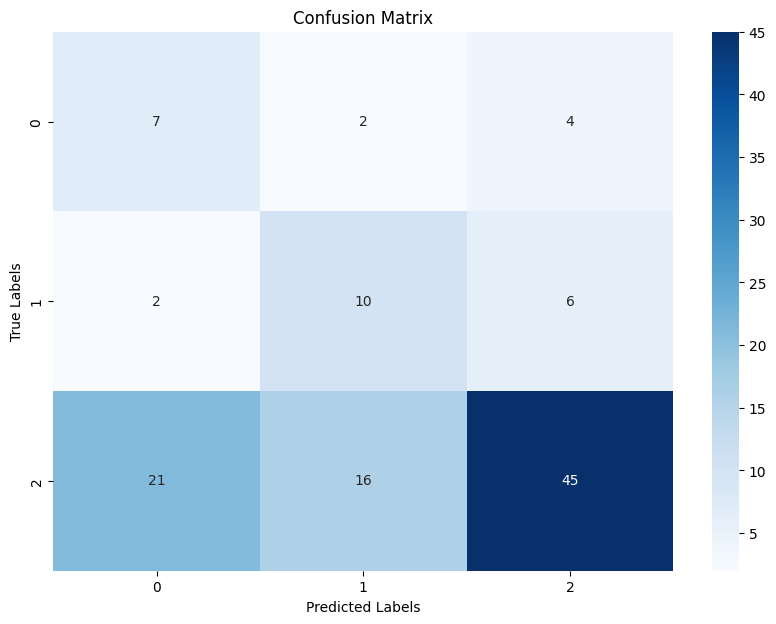

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

# Make predictions using the model
predictions = model.predict(val_generator, verbose=1)

# Apply custom threshold and classify the predictions
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)  # Class 0 if above threshold
    else:
        predicted_classes.append(np.argmax(pred))  # Otherwise, use argmax for other classes

# True labels from the validation generator
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy after applying threshold: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.46      0.34        13
           1       0.33      0.56      0.42        18
           2       0.84      0.62      0.71        82

    accuracy                           0.59       113
   macro avg       0.48      0.55      0.49       113
weighted avg       0.69      0.59      0.62       113



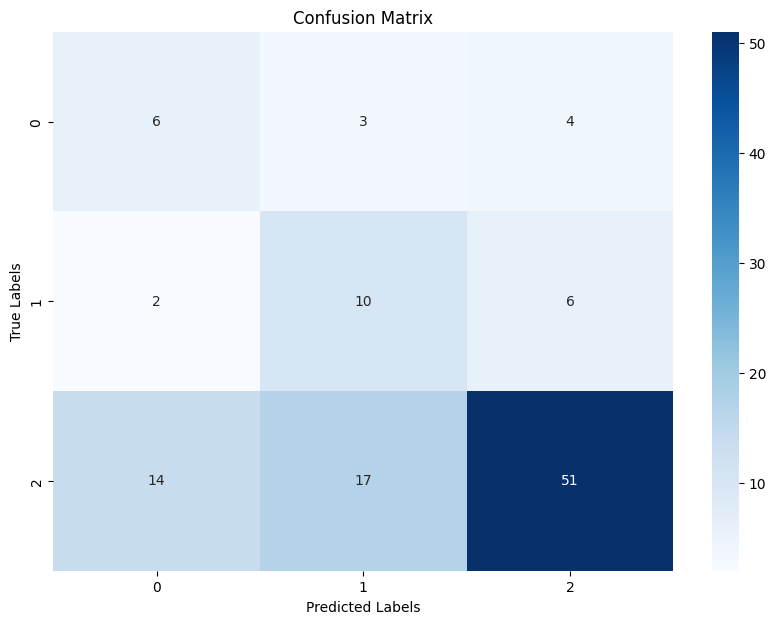

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming `model` is your trained model and `test_generator` is your data generator
# Make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.62      0.25        85
           1       0.10      0.26      0.15        77
           2       0.87      0.15      0.26       448

    accuracy                           0.23       610
   macro avg       0.38      0.34      0.22       610
weighted avg       0.67      0.23      0.24       610



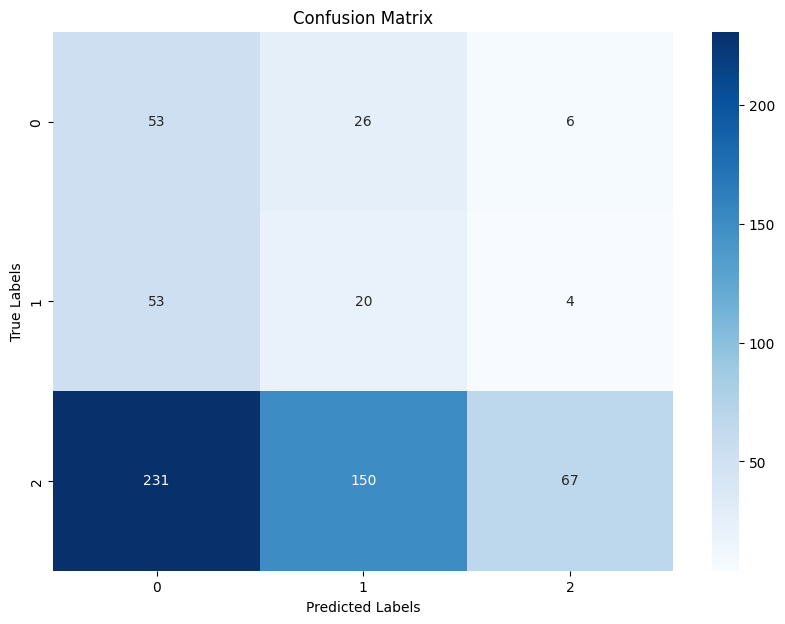

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

predictions = model.predict(val_generator, verbose=1)

# custom threshold
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)
    else:
        predicted_classes.append(np.argmax(pred))


true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

model.save('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_1_2/EfficientNetB0_L2_MoreThreasehold_23_Sept_2024_V3.h5')


In [ ]:

import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


### DenseNet201

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau

csv_logger = CSVLogger('densenet201_training_log.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)


# Load DenseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[csv_logger, early_stopping, reduce_lr]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'DenseNet201 Test accuracy: {test_accuracy:.4f}')


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 108s 143ms/step - accuracy: 0.4015 - loss: 2.2788 - val_accuracy: 0.4954 - val_loss: 1.0503 - learning_rate: 1.0000e-04
Epoch 2/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.4982 - loss: 1.0638 - val_accuracy: 0.5384 - val_loss: 0.9821 - learning_rate: 1.0000e-04
Epoch 3/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.5400 - loss: 0.9559 - val_accuracy: 0.5553 - val_loss: 0.9534 - learning_rate: 1.0000e-04
Epoch 4/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.5664 - loss: 0.9226 - val_accuracy: 0.5801 - val_loss: 0.9253 - learning_rate: 1.0000e-04
Epoch 5/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.5848 - loss: 0.8885 - val_accuracy: 0.5365 - val_loss: 0.9601 - learning_rate: 1.0000e-04
Epoch 6/25
445/445 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.5985 - loss: 0.8649 - val_accuracy: 0.5645 - val_loss: 0.9382 - learning_rate: 1.0000e-04

### ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau

# Load a pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_1_2/ResNet50_L2_MoreThreasehold_23_Sept_2024_V3.h5')

# csv_logger = CSVLogger('training_log.csv', append=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=25,
#     callbacks=[csv_logger, early_stopping, reduce_lr]
# )

# # Evaluate on the test set
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f'Test accuracy: {test_accuracy:.4f}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.31      0.24        13
           1       0.41      0.72      0.52        18
           2       0.82      0.60      0.69        82

    accuracy                           0.58       113
   macro avg       0.47      0.54      0.48       113
weighted avg       0.68      0.58      0.61       113



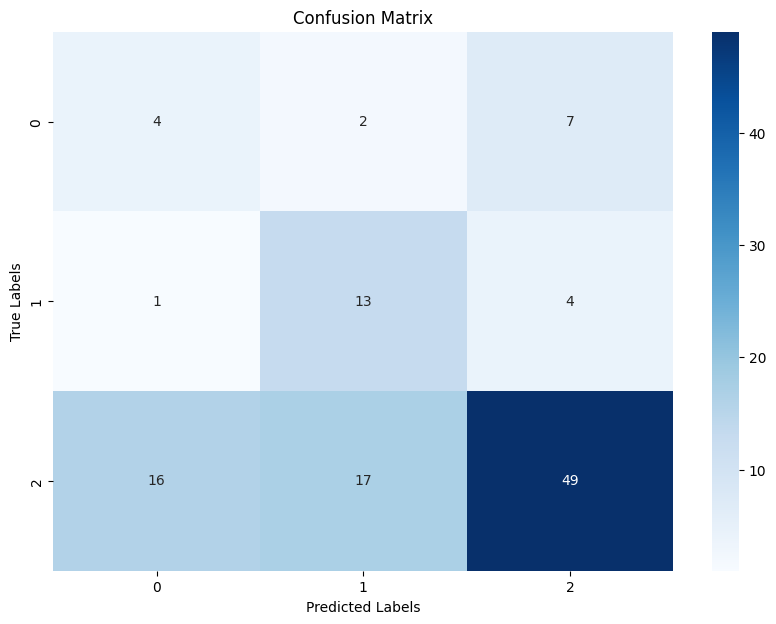

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming `model` is your trained model and `test_generator` is your data generator
# Make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.54      0.33        13
           1       0.41      0.72      0.52        18
           2       0.84      0.52      0.65        82

    accuracy                           0.56       113
   macro avg       0.49      0.60      0.50       113
weighted avg       0.70      0.56      0.59       113



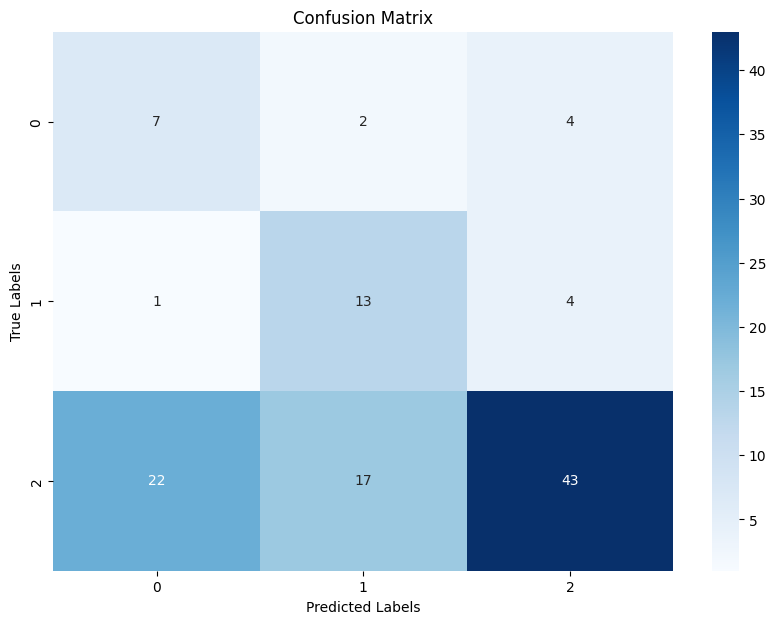

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

predictions = model.predict(val_generator, verbose=1)

# custom threshold
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)
    else:
        predicted_classes.append(np.argmax(pred))


true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

model.save('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_1_2/ResNet50_L2_MoreThreasehold_23_Sept_2024_V3.h5')


## Skin Tone 3+4 Mid

### Load our pre processed data easily keep only 3, 4 skin tone

In [ ]:
import pandas as pd
import os
from zipfile import ZipFile

# Define file paths
zip_file_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/all_images_trainAug_testNonAuh_V3_withSToneDF.zip'
unzip_dir = '/content/all_images'
metadata_csv_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/image_metadata_trainAug_testNonAuh_V3_withSToneDF.csv'

# Unzip the images folder (run only if not already unzipped)
if not os.path.exists(unzip_dir):
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print(f"Images unzipped to {unzip_dir}")

# Load the metadata DataFrame
df_all_images = pd.read_csv(metadata_csv_path)

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train']
df_test = df_all_images[df_all_images['set'] == 'test']

# Function to load images dynamically based on class label
def get_class_data(df, class_label):
    if class_label in df['three_partition_label'].values:
        class_data = df[df['three_partition_label'] == class_label]
        X = class_data['resized_image_path'].values
        y = class_data['three_partition_label'].values
        return X, y
    else:
        print(f"Class '{class_label}' not found in DataFrame.")
        return None, None

# Example: Load image paths and labels for 'malignant' class from train set
X_train_malignant, y_train_malignant = get_class_data(df_train, 'malignant')

# Example: Load image paths and labels for 'non-neoplastic' class from test set
X_test_non_neoplastic, y_test_non_neoplastic = get_class_data(df_test, 'non-neoplastic')

# Display counts
print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Verify the loaded data
print(df_test.head())
df_train.head()

Train set class distribution:
three_partition_label
benign            9719
non-neoplastic    9664
malignant         9574
Name: count, dtype: int64

Test set class distribution:
three_partition_label
non-neoplastic    2416
malignant          453
benign             447
Name: count, dtype: int64
                                      resized_image_path  \
13261  /content/all_images/b6f9c924bb3b864c03ecfad295...   
13262  /content/all_images/3e96f0e6bdf82fe4ee5d7635c7...   
13263  /content/all_images/abf70b58e93e881fdad4566809...   
13264  /content/all_images/e789130a814619c1773eef8643...   
13265  /content/all_images/60c20c7458e1a508b96bd1dec2...   

      three_partition_label   set  fitzpatrick_scale  
13261        non-neoplastic  test                  6  
13262                benign  test                  1  
13263                benign  test                  1  
13264             malignant  test                  6  
13265             malignant  test                  2  


resized_image_path three_partition_label  \
0  /content/all_images/96e320998184af49bfc791c8f1...             malignant   
1  /content/all_images/3b76144cda29793ac4bb709ab4...        non-neoplastic   
2  /content/all_images/da81b0441ab66a8c3f55489a0d...             malignant   
3  /content/all_images/72430e826363a44a2f9d5dd7e8...             malignant   
4  /content/all_images/860590217a382b642fe9755f80...        non-neoplastic   

     set  fitzpatrick_scale  
0  train                  3  
1  train                  2  
2  train                  1  
3  train                  4  
4  train                  3

<Figure size 1000x600 with 0 Axes>

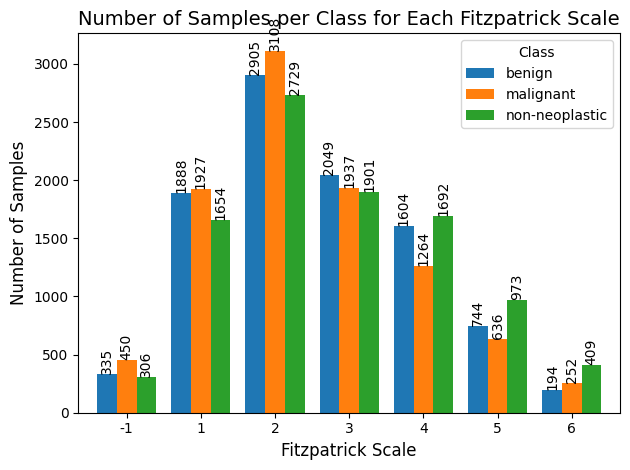

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'fitzpatrick_scale' and 'label', and count the number of samples
scale_class_counts = df_train.groupby(['fitzpatrick_scale', 'three_partition_label']).size().unstack(fill_value=0)

# Create the grouped bar chart
plt.figure(figsize=(10, 6))
ax = scale_class_counts.plot(kind='bar', stacked=False, width=0.8)

# Add labels and title
plt.title('Number of Samples per Class for Each Fitzpatrick Scale', fontsize=14)
plt.xlabel('Fitzpatrick Scale', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Class', loc='upper right')

# Display count values above each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load your data and initialize the LabelEncoder
df_all_images = pd.read_csv(metadata_csv_path)

# Initialize LabelEncoder
label_encoder = LabelEncoder()
df_all_images['three_partition_label'] = label_encoder.fit_transform(df_all_images['three_partition_label'])

# Print the class mapping
print("Class mapping:")
for index, class_label in enumerate(label_encoder.classes_):
    print(f"{index}: {class_label}")

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train'].copy()
df_test = df_all_images[df_all_images['set'] == 'test'].copy()
# df_test = df_test

# Apply filtering for specific scales in train and test sets
scales_to_keep = [-1]
df_train = df_train[df_train['fitzpatrick_scale'].isin(scales_to_keep)].copy()
df_test = df_test[df_test['fitzpatrick_scale'].isin(scales_to_keep)].copy()


print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Convert labels to string type for `class_mode='sparse'`
df_train['three_partition_label'] = df_train['three_partition_label'].astype(str)
df_test['three_partition_label'] = df_test['three_partition_label'].astype(str)

# Split df_train into training and validation sets
# df_test, df_val = train_test_split(df_test, test_size=0.50, stratify=df_test['three_partition_label'], random_state=42)

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    # dataframe=df_val,
    dataframe=df_test,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Class mapping:
0: benign
1: malignant
2: non-neoplastic
Train set class distribution:
three_partition_label
1    450
0    335
2    306
Name: count, dtype: int64

Test set class distribution:
three_partition_label
2    82
1    18
0    13
Name: count, dtype: int64
Found 1091 validated image filenames belonging to 3 classes.
Found 113 validated image filenames belonging to 3 classes.
Found 113 validated image filenames belonging to 3 classes.


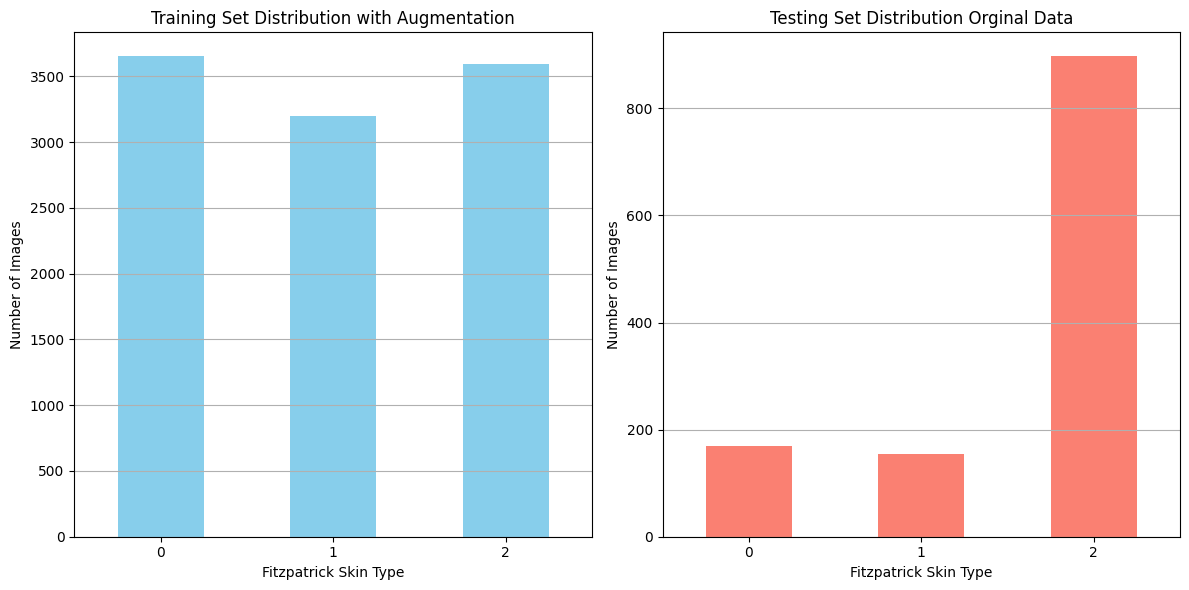

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

train_skin_type_counts = df_train['three_partition_label'].value_counts().sort_index()
test_skin_type_counts = df_test['three_partition_label'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_skin_type_counts.plot(kind='bar', color='skyblue')
plt.title('Training Set Distribution with Augmentation')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(len(train_skin_type_counts.index)), labels=train_skin_type_counts.index, rotation=0)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
test_skin_type_counts.plot(kind='bar', color='salmon')
plt.title('Testing Set Distribution Orginal Data')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(len(test_skin_type_counts.index)), labels=test_skin_type_counts.index, rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


#### See Last 20 train Image to be sure all goes well

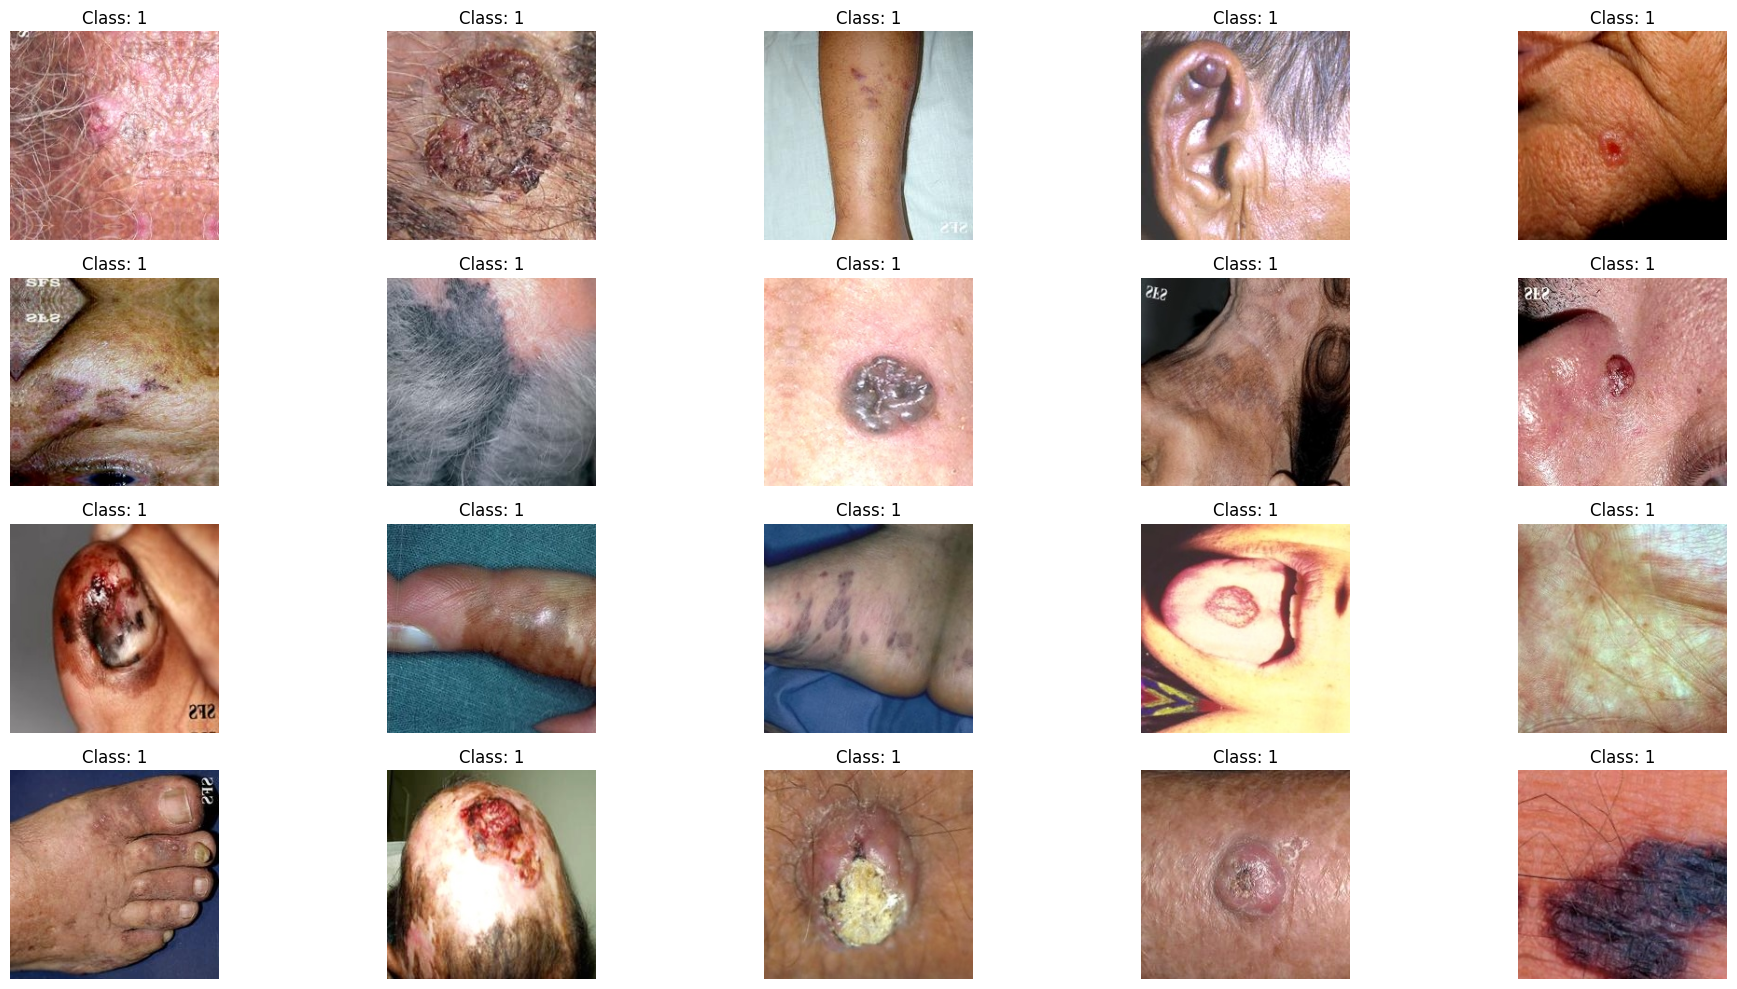

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Display the first 20 augmented images
sample = df_train.tail(20)

plt.figure(figsize=(20, 10))

for i, row in enumerate(sample.itertuples(), start=1):
    image_path = row.resized_image_path
    image = Image.open(image_path)

    plt.subplot(4, 5, i)
    plt.imshow(image)
    plt.title(f"Class: {row.three_partition_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau
import numpy as np

# Load the EfficientNetB0 model with ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 units
x = BatchNormalization()(x)  # Batch normalization for stability
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
predictions = Dense(3, activation='softmax')(x)  # Output layer for 3 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze the base model layers to train only the custom layers
for layer in base_model.layers:
    layer.trainable = False

csv_logger = CSVLogger('training_log.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# # Define custom class weights to improve recall for underperforming classes
# # Adjust these weights to balance the classes better
custom_class_weights = {
    0: 2.0,  # Higher weight for class 0 (benign)
    1: 3.0,  # Higher weight for class 1 (malignant)
    2: 1.0   # Lower weight for class 2 (non-neoplastic) since its recall is already good
}

# print("Custom Class Weights:", custom_class_weights)

# # Compile the model with custom class weights
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_3_4/EfficientNetB0_L2_MoreThreasehold_23_Sept_2024_V3.h5')

In [ ]:
# Train the model using custom class weights
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=custom_class_weights,
    callbacks=[csv_logger, early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


327/327 ━━━━━━━━━━━━━━━━━━━━ 55s 114ms/step - accuracy: 0.4838 - loss: 2.7411 - val_accuracy: 0.5029 - val_loss: 1.0967 - learning_rate: 1.0000e-04
Epoch 2/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.6413 - loss: 1.6077 - val_accuracy: 0.5839 - val_loss: 1.0638 - learning_rate: 1.0000e-04
Epoch 3/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.7042 - loss: 1.2343 - val_accuracy: 0.5897 - val_loss: 1.0636 - learning_rate: 1.0000e-04
Epoch 4/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.7498 - loss: 1.0221 - val_accuracy: 0.6118 - val_loss: 0.9790 - learning_rate: 1.0000e-04
Epoch 5/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.7694 - loss: 0.9328 - val_accuracy: 0.6167 - val_loss: 0.9720 - learning_rate: 1.0000e-04
Epoch 6/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.7964 - loss: 0.8051 - val_accuracy: 0.6323 - val_loss: 0.9750 - learning_rate: 1.0000e-04
Epoch 7/30
327/327 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accura

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.52      0.35        31
           1       0.47      0.57      0.52        40
           2       0.93      0.83      0.88       375

    accuracy                           0.79       446
   macro avg       0.55      0.64      0.58       446
weighted avg       0.84      0.79      0.81       446



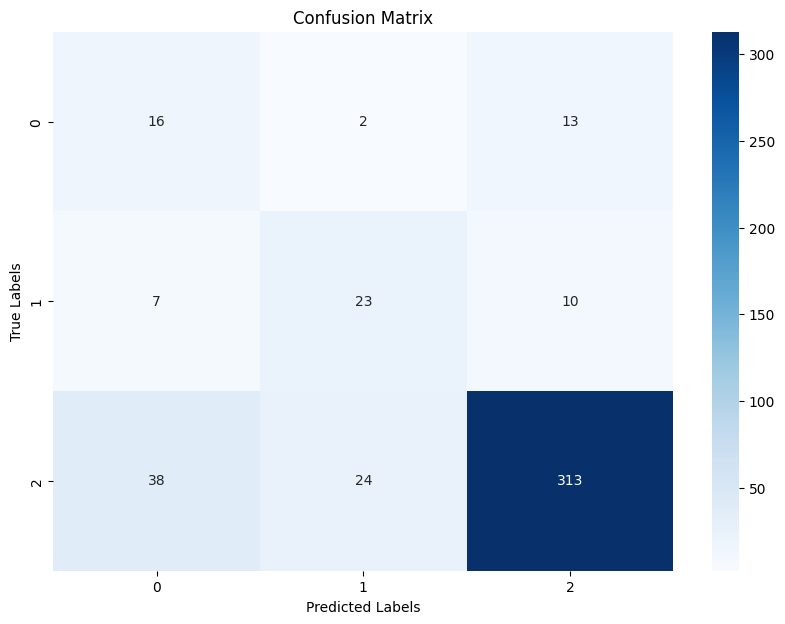

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming `model` is your trained model and `test_generator` is your data generator
# Make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5061 - loss: 1.5203 
Test accuracy: 48.67%


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.46      0.24        13
           1       0.34      0.56      0.43        18
           2       0.78      0.44      0.56        82

    accuracy                           0.46       113
   macro avg       0.43      0.49      0.41       113
weighted avg       0.64      0.46      0.50       113



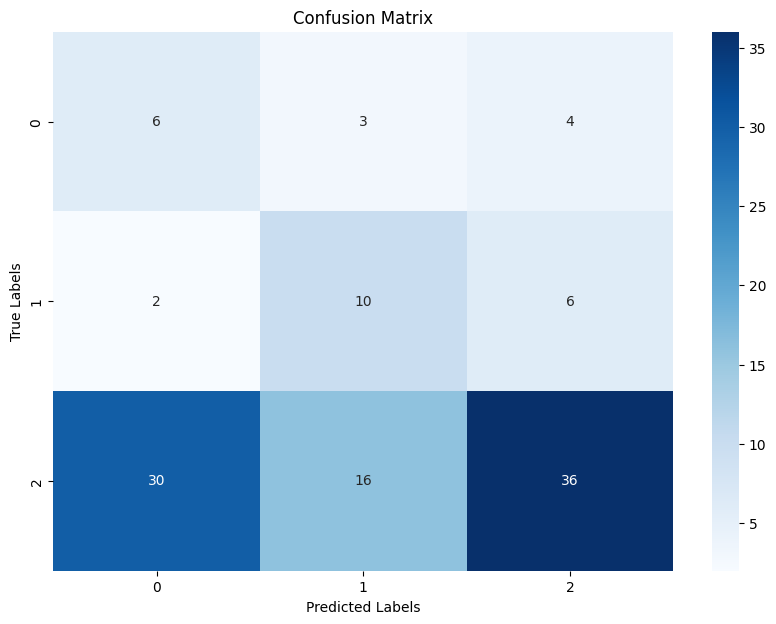

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

predictions = model.predict(val_generator, verbose=1)

# custom threshold
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)
    else:
        predicted_classes.append(np.argmax(pred))


true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.46      0.24        13
           1       0.34      0.56      0.43        18
           2       0.78      0.44      0.56        82

    accuracy                           0.46       113
   macro avg       0.43      0.49      0.41       113
weighted avg       0.64      0.46      0.50       113

Accuracy after applying threshold: 0.4602


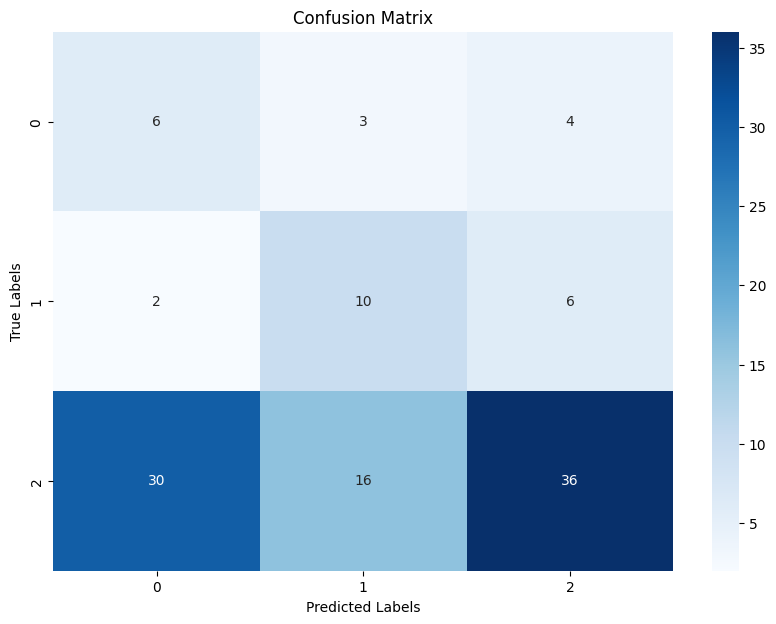

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

# Make predictions using the model
predictions = model.predict(val_generator, verbose=1)

# Apply custom threshold and classify the predictions
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)  # Class 0 if above threshold
    else:
        predicted_classes.append(np.argmax(pred))  # Otherwise, use argmax for other classes

# True labels from the validation generator
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy after applying threshold: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

model.save('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_3_4/EfficientNetB0_L2_MoreThreasehold_23_Sept_2024_V3.h5')


### ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau

# Load a pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

csv_logger = CSVLogger('training_log.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)


model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_3_4/ResNet50_L2_MoreThreasehold_23_Sept_2024_V3.h5')


In [ ]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[csv_logger, early_stopping, reduce_lr]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


327/327 ━━━━━━━━━━━━━━━━━━━━ 50s 127ms/step - accuracy: 0.5194 - loss: 1.1321 - val_accuracy: 0.7117 - val_loss: 0.7053 - learning_rate: 1.0000e-04
Epoch 2/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.7112 - loss: 0.6727 - val_accuracy: 0.7363 - val_loss: 0.6409 - learning_rate: 1.0000e-04
Epoch 3/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 31s 95ms/step - accuracy: 0.7837 - loss: 0.5335 - val_accuracy: 0.7240 - val_loss: 0.6565 - learning_rate: 1.0000e-04
Epoch 4/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 32s 95ms/step - accuracy: 0.8289 - loss: 0.4445 - val_accuracy: 0.7453 - val_loss: 0.6103 - learning_rate: 1.0000e-04
Epoch 5/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.8663 - loss: 0.3706 - val_accuracy: 0.7609 - val_loss: 0.5954 - learning_rate: 1.0000e-04
Epoch 6/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 31s 95ms/step - accuracy: 0.8899 - loss: 0.3094 - val_accuracy: 0.6912 - val_loss: 0.7186 - learning_rate: 1.0000e-04
Epoch 7/25
327/327 ━━━━━━━━━━━━━━━━━━━━ 31s 95ms/step - accura

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 968ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.31      0.28        13
           1       0.41      0.67      0.51        18
           2       0.85      0.71      0.77        82

    accuracy                           0.65       113
   macro avg       0.51      0.56      0.52       113
weighted avg       0.71      0.65      0.67       113



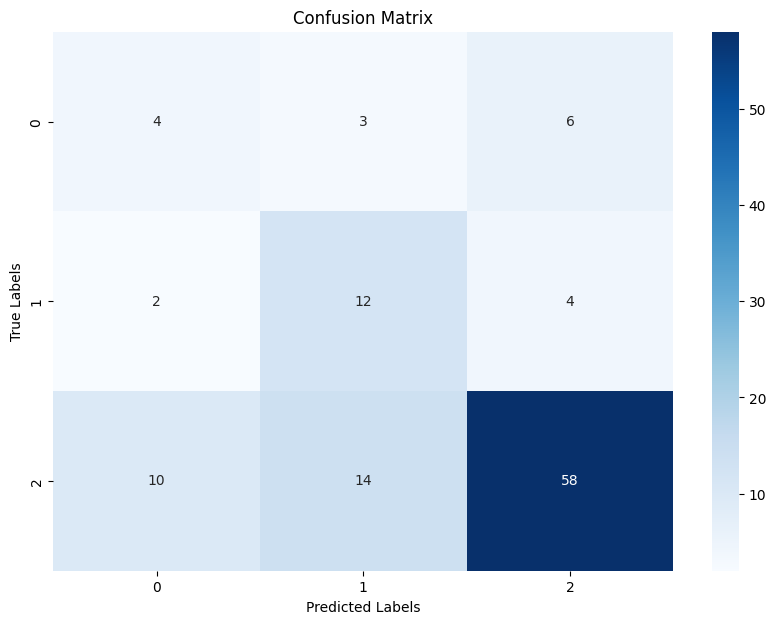

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming `model` is your trained model and `test_generator` is your data generator
# Make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.38      0.28        13
           1       0.44      0.67      0.53        18
           2       0.87      0.67      0.76        82

    accuracy                           0.64       113
   macro avg       0.51      0.57      0.52       113
weighted avg       0.73      0.64      0.67       113



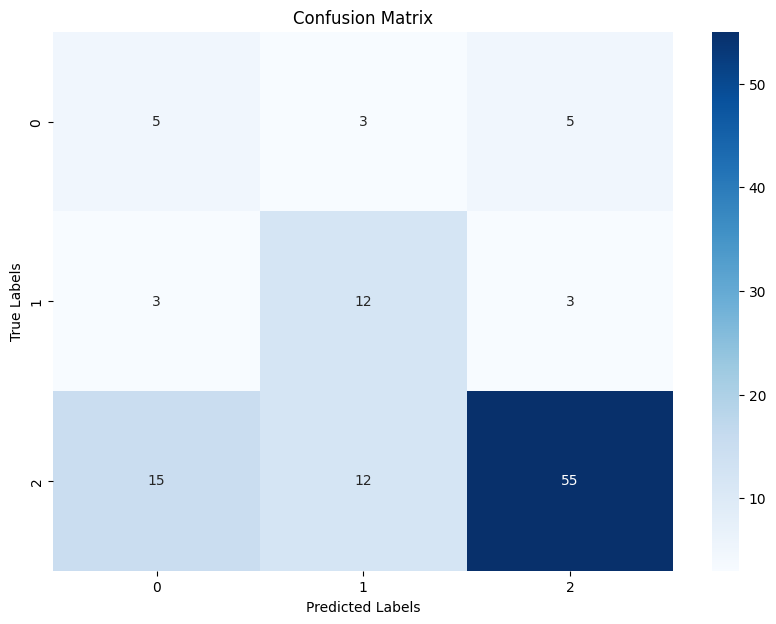

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

predictions = model.predict(val_generator, verbose=1)

# custom threshold
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)
    else:
        predicted_classes.append(np.argmax(pred))


true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

model.save('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_3_4/ResNet50_L2_MoreThreasehold_23_Sept_2024_V3.h5')


## Skin Tone 5+6 Darker

### Load our pre processed data easily keep only 3, 4 skin tone

In [ ]:
import pandas as pd
import os
from zipfile import ZipFile

# Define file paths
zip_file_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/all_images_trainAug_testNonAuh_V3_withSToneDF.zip'
unzip_dir = '/content/all_images'
metadata_csv_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/image_metadata_trainAug_testNonAuh_V3_withSToneDF.csv'

# Unzip the images folder (run only if not already unzipped)
if not os.path.exists(unzip_dir):
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print(f"Images unzipped to {unzip_dir}")

# Load the metadata DataFrame
df_all_images = pd.read_csv(metadata_csv_path)

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train']
df_test = df_all_images[df_all_images['set'] == 'test']

# Function to load images dynamically based on class label
def get_class_data(df, class_label):
    if class_label in df['three_partition_label'].values:
        class_data = df[df['three_partition_label'] == class_label]
        X = class_data['resized_image_path'].values
        y = class_data['three_partition_label'].values
        return X, y
    else:
        print(f"Class '{class_label}' not found in DataFrame.")
        return None, None

# Example: Load image paths and labels for 'malignant' class from train set
X_train_malignant, y_train_malignant = get_class_data(df_train, 'malignant')

# Example: Load image paths and labels for 'non-neoplastic' class from test set
X_test_non_neoplastic, y_test_non_neoplastic = get_class_data(df_test, 'non-neoplastic')

# Display counts
print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Verify the loaded data
print(df_test.head())
df_train.head()

Train set class distribution:
three_partition_label
benign            9719
non-neoplastic    9664
malignant         9574
Name: count, dtype: int64

Test set class distribution:
three_partition_label
non-neoplastic    2416
malignant          453
benign             447
Name: count, dtype: int64
                                      resized_image_path  \
13261  /content/all_images/b6f9c924bb3b864c03ecfad295...   
13262  /content/all_images/3e96f0e6bdf82fe4ee5d7635c7...   
13263  /content/all_images/abf70b58e93e881fdad4566809...   
13264  /content/all_images/e789130a814619c1773eef8643...   
13265  /content/all_images/60c20c7458e1a508b96bd1dec2...   

      three_partition_label   set  fitzpatrick_scale  
13261        non-neoplastic  test                  6  
13262                benign  test                  1  
13263                benign  test                  1  
13264             malignant  test                  6  
13265             malignant  test                  2  


resized_image_path three_partition_label  \
0  /content/all_images/96e320998184af49bfc791c8f1...             malignant   
1  /content/all_images/3b76144cda29793ac4bb709ab4...        non-neoplastic   
2  /content/all_images/da81b0441ab66a8c3f55489a0d...             malignant   
3  /content/all_images/72430e826363a44a2f9d5dd7e8...             malignant   
4  /content/all_images/860590217a382b642fe9755f80...        non-neoplastic   

     set  fitzpatrick_scale  
0  train                  3  
1  train                  2  
2  train                  1  
3  train                  4  
4  train                  3

<Figure size 1000x600 with 0 Axes>

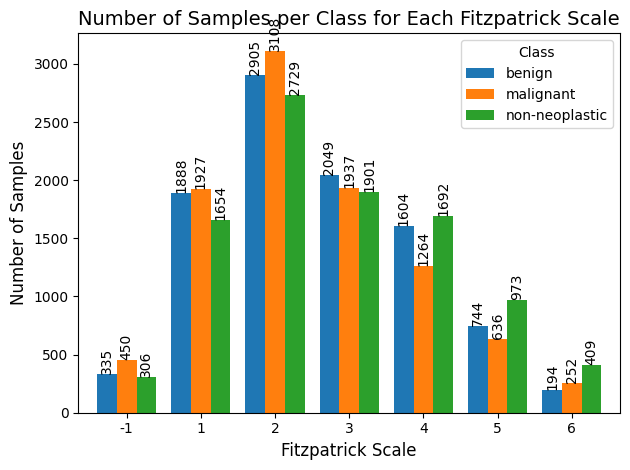

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'fitzpatrick_scale' and 'label', and count the number of samples
scale_class_counts = df_train.groupby(['fitzpatrick_scale', 'three_partition_label']).size().unstack(fill_value=0)

# Create the grouped bar chart
plt.figure(figsize=(10, 6))
ax = scale_class_counts.plot(kind='bar', stacked=False, width=0.8)

# Add labels and title
plt.title('Number of Samples per Class for Each Fitzpatrick Scale', fontsize=14)
plt.xlabel('Fitzpatrick Scale', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Class', loc='upper right')

# Display count values above each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load your data and initialize the LabelEncoder
df_all_images = pd.read_csv(metadata_csv_path)

# Initialize LabelEncoder
label_encoder = LabelEncoder()
df_all_images['three_partition_label'] = label_encoder.fit_transform(df_all_images['three_partition_label'])

# Print the class mapping
print("Class mapping:")
for index, class_label in enumerate(label_encoder.classes_):
    print(f"{index}: {class_label}")

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train'].copy()
df_test = df_all_images[df_all_images['set'] == 'test'].copy()
# df_test = df_test

# Apply filtering for specific scales in train and test sets
scales_to_keep = [-1]
df_train = df_train[df_train['fitzpatrick_scale'].isin(scales_to_keep)].copy()
df_test = df_test[df_test['fitzpatrick_scale'].isin(scales_to_keep)].copy()


print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Convert labels to string type for `class_mode='sparse'`
df_train['three_partition_label'] = df_train['three_partition_label'].astype(str)
df_test['three_partition_label'] = df_test['three_partition_label'].astype(str)

# Split df_train into training and validation sets
# df_test, df_val = train_test_split(df_test, test_size=0.50, stratify=df_test['three_partition_label'], random_state=42)

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    # dataframe=df_val,
    dataframe=df_test,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Class mapping:
0: benign
1: malignant
2: non-neoplastic
Train set class distribution:
three_partition_label
1    450
0    335
2    306
Name: count, dtype: int64

Test set class distribution:
three_partition_label
2    82
1    18
0    13
Name: count, dtype: int64
Found 1091 validated image filenames belonging to 3 classes.
Found 113 validated image filenames belonging to 3 classes.
Found 113 validated image filenames belonging to 3 classes.


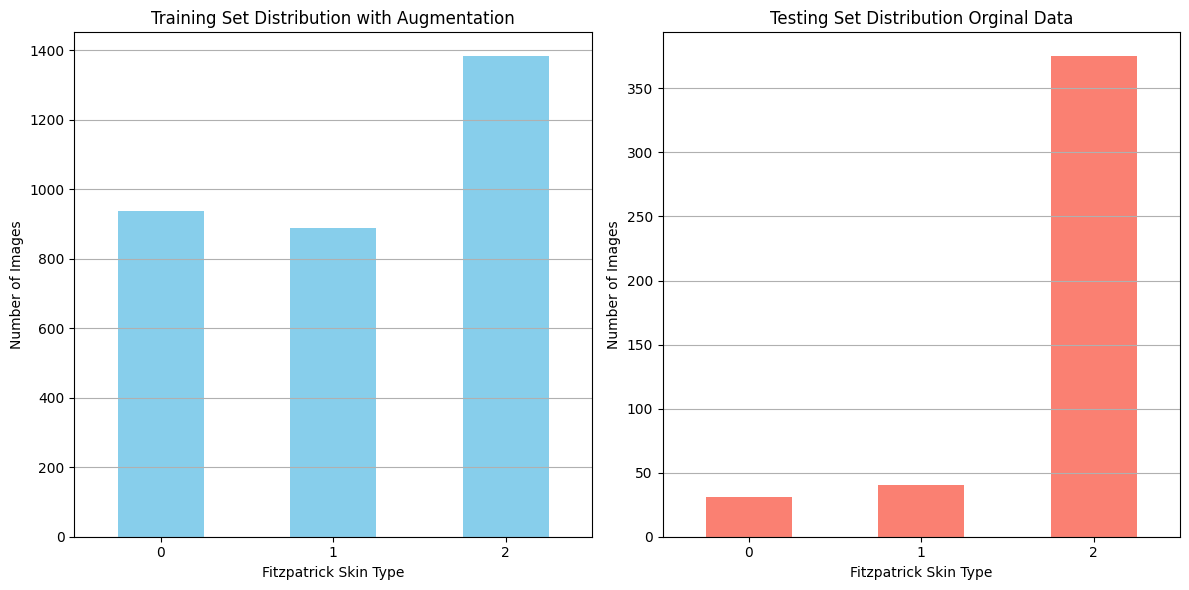

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

train_skin_type_counts = df_train['three_partition_label'].value_counts().sort_index()
test_skin_type_counts = df_test['three_partition_label'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_skin_type_counts.plot(kind='bar', color='skyblue')
plt.title('Training Set Distribution with Augmentation')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(len(train_skin_type_counts.index)), labels=train_skin_type_counts.index, rotation=0)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
test_skin_type_counts.plot(kind='bar', color='salmon')
plt.title('Testing Set Distribution Orginal Data')
plt.xlabel('Fitzpatrick Skin Type')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(len(test_skin_type_counts.index)), labels=test_skin_type_counts.index, rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


#### See Last 20 train Image to be sure all goes well

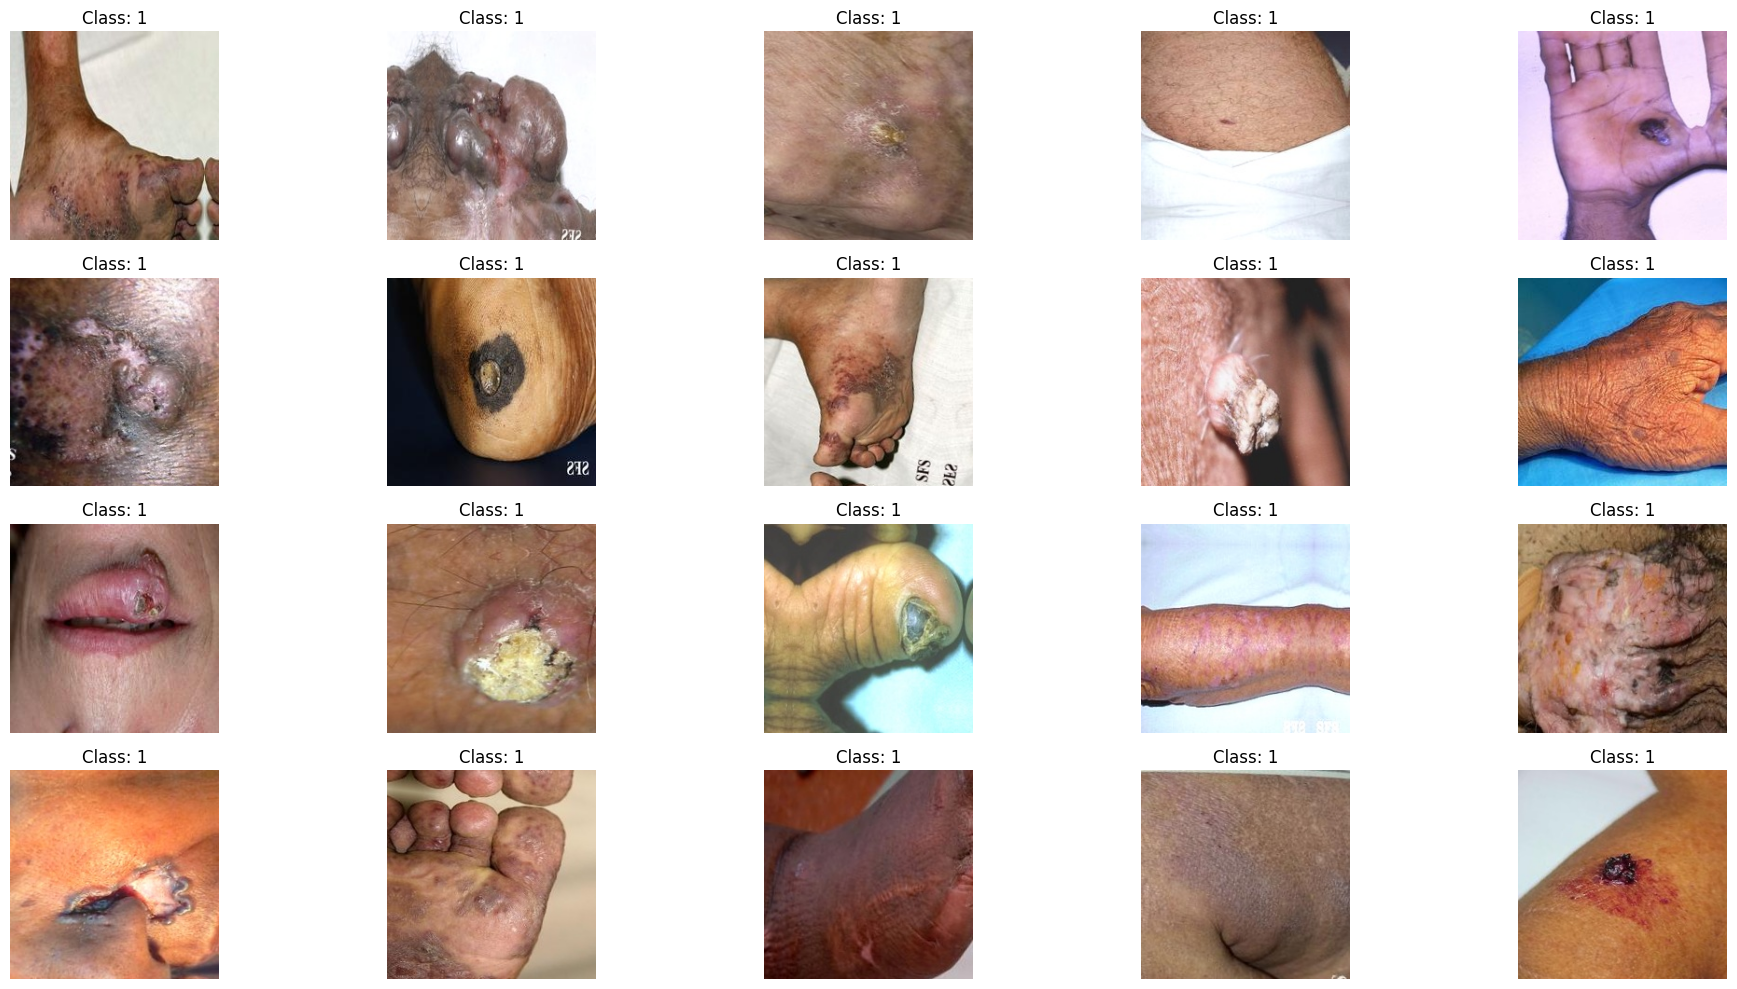

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Display the first 20 augmented images
sample = df_train.tail(20)

plt.figure(figsize=(20, 10))

for i, row in enumerate(sample.itertuples(), start=1):
    image_path = row.resized_image_path
    image = Image.open(image_path)

    plt.subplot(4, 5, i)
    plt.imshow(image)
    plt.title(f"Class: {row.three_partition_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau
import numpy as np

# Load the EfficientNetB0 model with ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 units
x = BatchNormalization()(x)  # Batch normalization for stability
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
predictions = Dense(3, activation='softmax')(x)  # Output layer for 3 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze the base model layers to train only the custom layers
for layer in base_model.layers:
    layer.trainable = False

csv_logger = CSVLogger('training_log.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# # Define custom class weights to improve recall for underperforming classes
# # Adjust these weights to balance the classes better
custom_class_weights = {
    0: 2.0,  # Higher weight for class 0 (benign)
    1: 3.0,  # Higher weight for class 1 (malignant)
    2: 1.0   # Lower weight for class 2 (non-neoplastic) since its recall is already good
}

# print("Custom Class Weights:", custom_class_weights)

# # Compile the model with custom class weights
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_5_6/EfficientNetB0_L2_MoreThreasehold_23_Sept_2024_V3.h5')

In [ ]:


# Train the model using custom class weights
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=custom_class_weights,
    callbacks=[csv_logger, early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 44s 270ms/step - accuracy: 0.4436 - loss: 2.7789 - val_accuracy: 0.5336 - val_loss: 0.9607 - learning_rate: 1.0000e-04
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6516 - loss: 1.3882 - val_accuracy: 0.6143 - val_loss: 0.8824 - learning_rate: 1.0000e-04
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7485 - loss: 1.0256 - val_accuracy: 0.6076 - val_loss: 0.9137 - learning_rate: 1.0000e-04
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.7853 - loss: 0.8185 - val_accuracy: 0.6839 - val_loss: 0.8036 - learning_rate: 1.0000e-04
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.8166 - loss: 0.7150 - val_accuracy: 0.6996 - val_loss: 0.7752 - learning_rate: 1.0000e-04
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.8347 - loss: 0.6059 - val_accuracy: 0.7197 - val_loss: 0.7749 - learning_rate: 1.0000e-04
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.15      0.13        13
           1       0.28      0.72      0.41        18
           2       0.76      0.45      0.56        82

    accuracy                           0.46       113
   macro avg       0.38      0.44      0.37       113
weighted avg       0.61      0.46      0.49       113



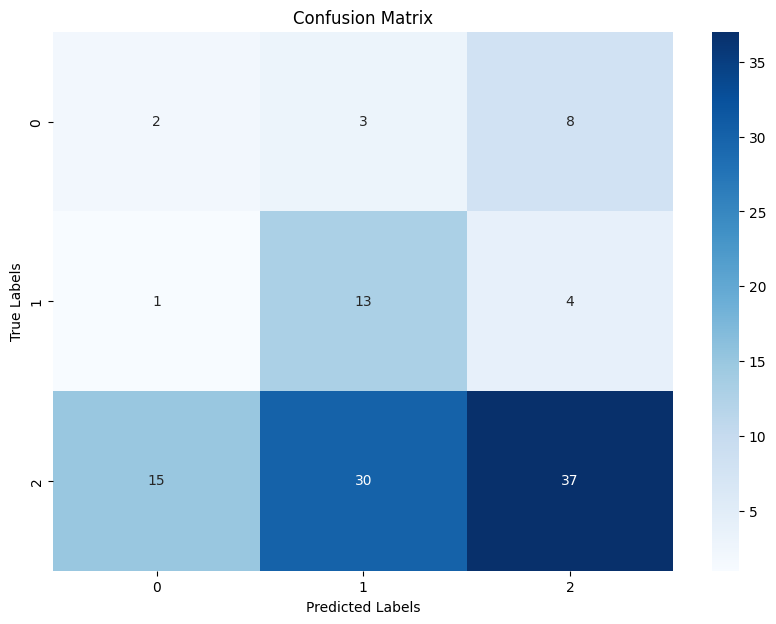

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5000 - loss: 1.6086 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4820 - loss: 1.7943
Test accuracy: 46.02%


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.23      0.16        13
           1       0.26      0.61      0.36        18
           2       0.76      0.43      0.55        82

    accuracy                           0.43       113
   macro avg       0.38      0.42      0.36       113
weighted avg       0.61      0.43      0.47       113



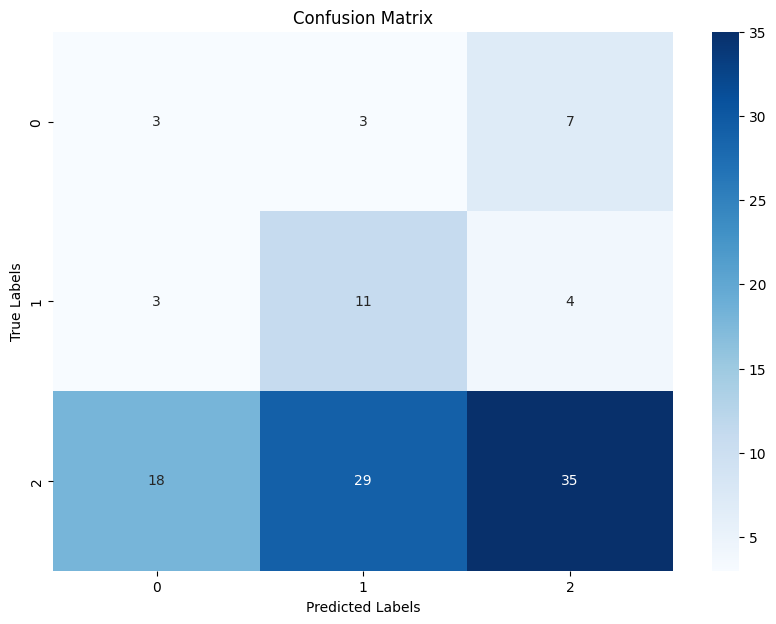

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

predictions = model.predict(val_generator, verbose=1)

# custom threshold
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)
    else:
        predicted_classes.append(np.argmax(pred))


true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

model.save('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_5_6/EfficientNetB0_L2_MoreThreasehold_23_Sept_2024_V3.h5')


### ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau

# Load a pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_5_6/ResNet50_L2_MoreThreasehold_23_Sept_2024_V3.h5')


In [ ]:


csv_logger = CSVLogger('training_log.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[csv_logger, early_stopping, reduce_lr]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')


Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.4742 - loss: 1.2633 - val_accuracy: 0.7803 - val_loss: 0.5623 - learning_rate: 1.0000e-04
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.7098 - loss: 0.6821 - val_accuracy: 0.7937 - val_loss: 0.5114 - learning_rate: 1.0000e-04
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7857 - loss: 0.5151 - val_accuracy: 0.7848 - val_loss: 0.5203 - learning_rate: 1.0000e-04
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.8487 - loss: 0.4028 - val_accuracy: 0.7713 - val_loss: 0.5399 - learning_rate: 1.0000e-04
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.8973 - loss: 0.3116 - val_accuracy: 0.7848 - val_loss: 0.5084 - learning_rate: 1.0000e-04
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9150 - loss: 0.2559 - val_accuracy: 0.8206 - val_loss: 0.4664 - learning_rate: 1.0000e-04
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/s

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 959ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.27      0.67      0.39        18
           2       0.75      0.56      0.64        82

    accuracy                           0.51       113
   macro avg       0.34      0.41      0.34       113
weighted avg       0.59      0.51      0.53       113



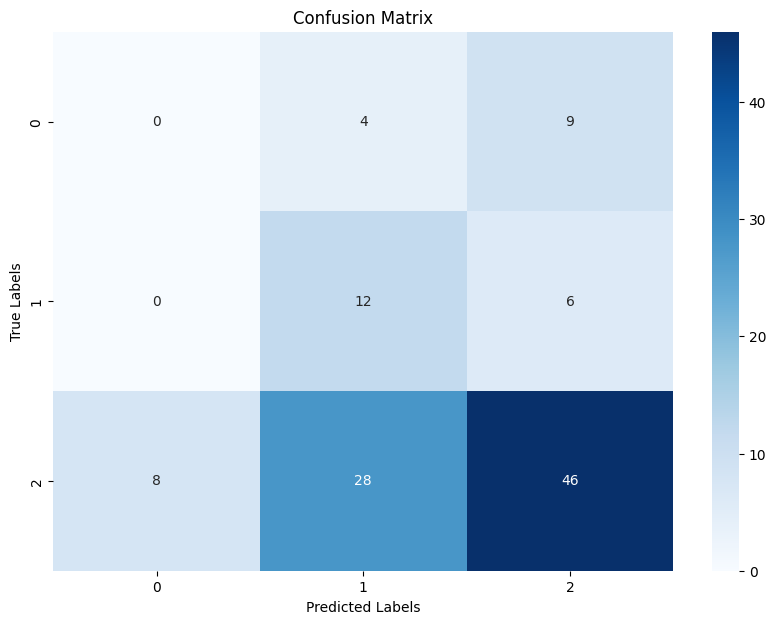

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming `model` is your trained model and `test_generator` is your data generator
# Make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.26      0.61      0.37        18
           2       0.74      0.52      0.61        82

    accuracy                           0.48       113
   macro avg       0.33      0.38      0.33       113
weighted avg       0.58      0.48      0.50       113



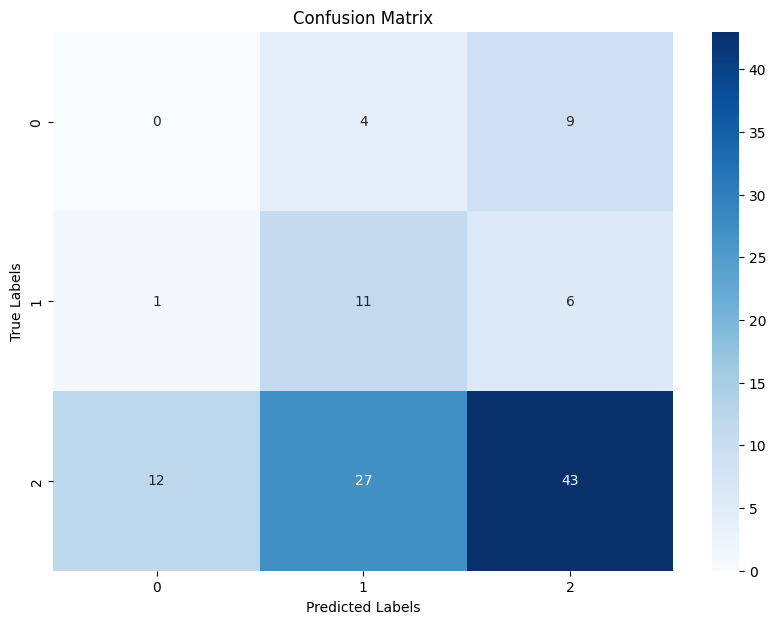

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

predictions = model.predict(val_generator, verbose=1)

# custom threshold
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)
    else:
        predicted_classes.append(np.argmax(pred))


true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

model.save('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_5_6/ResNet50_L2_MoreThreasehold_23_Sept_2024_V3.h5')


## All TEST

In [ ]:
import pandas as pd
import os
from zipfile import ZipFile

# Define file paths
zip_file_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/all_images_trainAug_testNonAuh_V3_withSToneDF.zip'
unzip_dir = '/content/all_images'
metadata_csv_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Fitzptrick_17k/V2/image_metadata_trainAug_testNonAuh_V3_withSToneDF.csv'

# Unzip the images folder (run only if not already unzipped)
if not os.path.exists(unzip_dir):
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)
    print(f"Images unzipped to {unzip_dir}")

# Load the metadata DataFrame
df_all_images = pd.read_csv(metadata_csv_path)

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train']
df_test = df_all_images[df_all_images['set'] == 'test']

# Function to load images dynamically based on class label
def get_class_data(df, class_label):
    if class_label in df['three_partition_label'].values:
        class_data = df[df['three_partition_label'] == class_label]
        X = class_data['resized_image_path'].values
        y = class_data['three_partition_label'].values
        return X, y
    else:
        print(f"Class '{class_label}' not found in DataFrame.")
        return None, None

# Example: Load image paths and labels for 'malignant' class from train set
X_train_malignant, y_train_malignant = get_class_data(df_train, 'malignant')

# Example: Load image paths and labels for 'non-neoplastic' class from test set
X_test_non_neoplastic, y_test_non_neoplastic = get_class_data(df_test, 'non-neoplastic')

# Display counts
print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Verify the loaded data
print(df_test.head())
df_train.head()

Images unzipped to /content/all_images
Train set class distribution:
three_partition_label
benign            9719
non-neoplastic    9664
malignant         9574
Name: count, dtype: int64

Test set class distribution:
three_partition_label
non-neoplastic    2416
malignant          453
benign             447
Name: count, dtype: int64
                                      resized_image_path  \
13261  /content/all_images/b6f9c924bb3b864c03ecfad295...   
13262  /content/all_images/3e96f0e6bdf82fe4ee5d7635c7...   
13263  /content/all_images/abf70b58e93e881fdad4566809...   
13264  /content/all_images/e789130a814619c1773eef8643...   
13265  /content/all_images/60c20c7458e1a508b96bd1dec2...   

      three_partition_label   set  fitzpatrick_scale  
13261        non-neoplastic  test                  6  
13262                benign  test                  1  
13263                benign  test                  1  
13264             malignant  test                  6  
13265             malignant  te

resized_image_path three_partition_label  \
0  /content/all_images/96e320998184af49bfc791c8f1...             malignant   
1  /content/all_images/3b76144cda29793ac4bb709ab4...        non-neoplastic   
2  /content/all_images/da81b0441ab66a8c3f55489a0d...             malignant   
3  /content/all_images/72430e826363a44a2f9d5dd7e8...             malignant   
4  /content/all_images/860590217a382b642fe9755f80...        non-neoplastic   

     set  fitzpatrick_scale  
0  train                  3  
1  train                  2  
2  train                  1  
3  train                  4  
4  train                  3

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load your data and initialize the LabelEncoder
df_all_images = pd.read_csv(metadata_csv_path)

# Initialize LabelEncoder
label_encoder = LabelEncoder()
df_all_images['three_partition_label'] = label_encoder.fit_transform(df_all_images['three_partition_label'])

# Print the class mapping
print("Class mapping:")
for index, class_label in enumerate(label_encoder.classes_):
    print(f"{index}: {class_label}")

# Separate into train and test sets
df_train = df_all_images[df_all_images['set'] == 'train'].copy()
df_test = df_all_images[df_all_images['set'] == 'test'].copy()
# df_test = df_test

# Apply filtering for specific scales in train and test sets
# scales_to_keep = [-1]
# df_train = df_train[df_train['fitzpatrick_scale'].isin(scales_to_keep)].copy()
# df_test = df_test[df_test['fitzpatrick_scale'].isin(scales_to_keep)].copy()


print("Train set class distribution:")
print(df_train['three_partition_label'].value_counts())

print("\nTest set class distribution:")
print(df_test['three_partition_label'].value_counts())

# Convert labels to string type for `class_mode='sparse'`
df_train['three_partition_label'] = df_train['three_partition_label'].astype(str)
df_test['three_partition_label'] = df_test['three_partition_label'].astype(str)

# Split df_train into training and validation sets
# df_test, df_val = train_test_split(df_test, test_size=0.50, stratify=df_test['three_partition_label'], random_state=42)

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    # dataframe=df_val,
    dataframe=df_test,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='resized_image_path',
    y_col='three_partition_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Class mapping:
0: benign
1: malignant
2: non-neoplastic
Train set class distribution:
three_partition_label
0    9719
2    9664
1    9574
Name: count, dtype: int64

Test set class distribution:
three_partition_label
2    2416
1     453
0     447
Name: count, dtype: int64
Found 28957 validated image filenames belonging to 3 classes.
Found 3316 validated image filenames belonging to 3 classes.
Found 3316 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau
import numpy as np

# Load the EfficientNetB0 model with ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 units
x = BatchNormalization()(x)  # Batch normalization for stability
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
predictions = Dense(3, activation='softmax')(x)  # Output layer for 3 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze the base model layers to train only the custom layers
for layer in base_model.layers:
    layer.trainable = False

csv_logger = CSVLogger('training_log.csv', append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# # Define custom class weights to improve recall for underperforming classes
# # Adjust these weights to balance the classes better
custom_class_weights = {
    0: 2.0,  # Higher weight for class 0 (benign)
    1: 3.0,  # Higher weight for class 1 (malignant)
    2: 1.0   # Lower weight for class 2 (non-neoplastic) since its recall is already good
}

# print("Custom Class Weights:", custom_class_weights)

# # Compile the model with custom class weights
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_1_to_6/EfficientNetB0_L2_MoreThreasehold_23_Sept_2024_V3.h5')

# loading now another best model to check which actual best
model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/Final_bestRecall/EfficientNetB0_L2_MoreThreasehold_18_Sept_2024_V3.h5')


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:


# Train the model using custom class weights
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=custom_class_weights,
    callbacks=[csv_logger, early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


905/905 ━━━━━━━━━━━━━━━━━━━━ 88s 78ms/step - accuracy: 0.5167 - loss: 2.4553 - val_accuracy: 0.5386 - val_loss: 1.0853 - learning_rate: 1.0000e-04
Epoch 2/30
905/905 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.6294 - loss: 1.5973 - val_accuracy: 0.5627 - val_loss: 1.0343 - learning_rate: 1.0000e-04
Epoch 3/30
905/905 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.6834 - loss: 1.3163 - val_accuracy: 0.5995 - val_loss: 0.9787 - learning_rate: 1.0000e-04
Epoch 4/30
905/905 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.7121 - loss: 1.1541 - val_accuracy: 0.6071 - val_loss: 0.9779 - learning_rate: 1.0000e-04
Epoch 5/30
905/905 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.7457 - loss: 1.0159 - val_accuracy: 0.6451 - val_loss: 0.8623 - learning_rate: 1.0000e-04
Epoch 6/30
905/905 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.7722 - loss: 0.9104 - val_accuracy: 0.6613 - val_loss: 0.8374 - learning_rate: 1.0000e-04
Epoch 7/30
905/905 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accurac

  3/104 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.59      0.49       447
           1       0.51      0.76      0.61       453
           2       0.91      0.76      0.83      2416

    accuracy                           0.74      3316
   macro avg       0.61      0.70      0.64      3316
weighted avg       0.79      0.74      0.75      3316



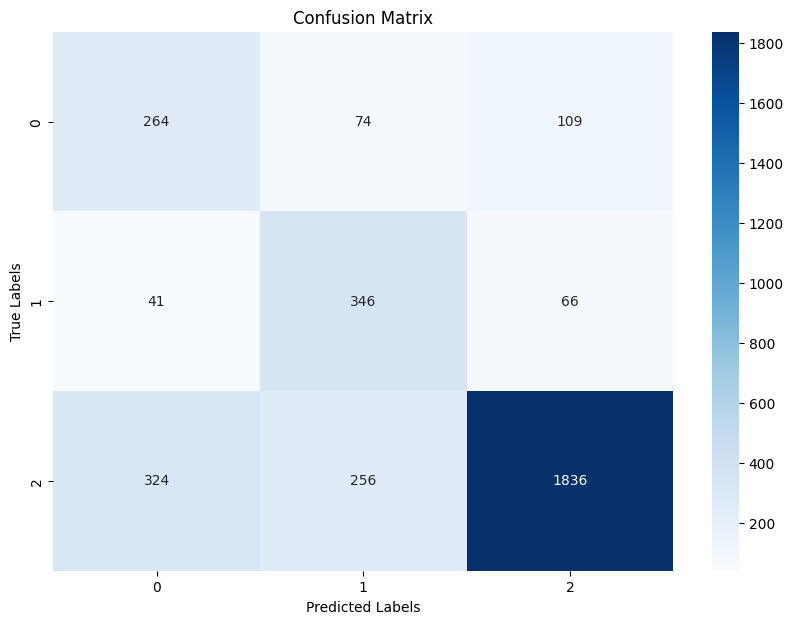

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming `model` is your trained model and `test_generator` is your data generator
# Make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Predict using the test generator
predictions = model.predict(test_generator, verbose=1)

# Get predicted class indices (argmax)
predicted_classes = np.argmax(predictions, axis=1)

# True labels from the test generator
true_classes = test_generator.classes

# Get the corresponding filenames
filenames = test_generator.filenames

# Decode the predicted and true labels back to their original class names
class_indices = test_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Decode predictions and true labels to class names
predicted_class_names = [index_to_class[i] for i in predicted_classes]
true_class_names = [index_to_class[i] for i in true_classes]

# Store the results in a DataFrame
df_results = pd.DataFrame({
    'resized_image_path': filenames,
    'predicted_class': predicted_class_names,
    'true_class': true_class_names
})

# Identify correct predictions
df_correct_predictions = df_results[df_results['predicted_class'] == df_results['true_class']]

# Merge with the original metadata (df_all_images) to keep all columns
df_correct_predictions = pd.merge(
    df_correct_predictions,
    df_all_images,
    left_on='resized_image_path',
    right_on='resized_image_path',
    how='left'
)

# Display the DataFrame with correct predictions and all original columns
print(df_correct_predictions.head())

# Optionally save the correct predictions to a CSV file
df_correct_predictions.to_csv('correct_predictions_with_metadata.csv', index=False)


104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step
                                  resized_image_path predicted_class  \
0  /content/all_images/b6f9c924bb3b864c03ecfad295...               2   
1  /content/all_images/3e96f0e6bdf82fe4ee5d7635c7...               0   
2  /content/all_images/e789130a814619c1773eef8643...               1   
3  /content/all_images/60c20c7458e1a508b96bd1dec2...               1   
4  /content/all_images/e95dc7cb6e69674a28b19ee688...               2   

  true_class  three_partition_label   set  fitzpatrick_scale  
0          2                      2  test                  6  
1          0                      0  test                  1  
2          1                      1  test                  6  
3          1                      1  test                  2  
4          2                      2  test                  5  


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7290 - loss: 0.8420
Test accuracy: 71.22%


 3/52 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.70      0.50       224
           1       0.53      0.76      0.62       226
           2       0.93      0.72      0.81      1208

    accuracy                           0.72      1658
   macro avg       0.62      0.72      0.64      1658
weighted avg       0.80      0.72      0.74      1658

Accuracy after applying threshold: 0.7189


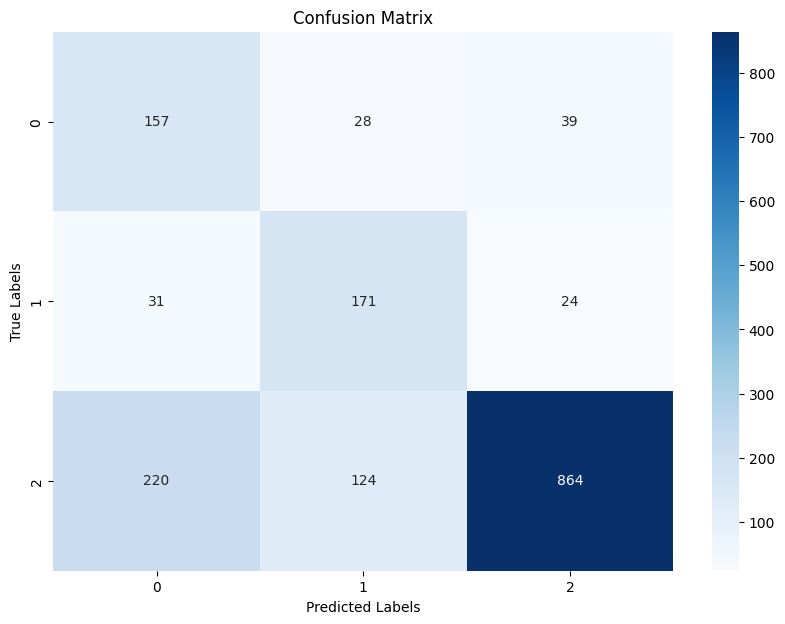

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

# Make predictions using the model
predictions = model.predict(val_generator, verbose=1)

# Apply custom threshold and classify the predictions
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)  # Class 0 if above threshold
    else:
        predicted_classes.append(np.argmax(pred))  # Otherwise, use argmax for other classes

# True labels from the validation generator
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy after applying threshold: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.77      0.48        13
           1       0.48      0.78      0.60        18
           2       0.91      0.61      0.73        82

    accuracy                           0.65       113
   macro avg       0.58      0.72      0.60       113
weighted avg       0.78      0.65      0.68       113



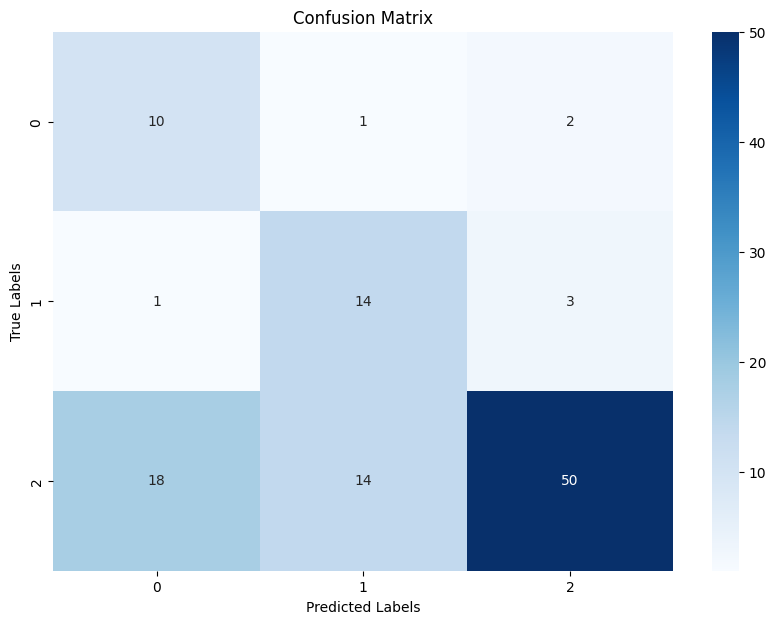

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

predictions = model.predict(val_generator, verbose=1)

# custom threshold
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)
    else:
        predicted_classes.append(np.argmax(pred))


true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

model.save('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/SkinTone_1_to_6/EfficientNetB0_L2_MoreThreasehold_23_Sept_2024_V3.h5')


### ResNet50 old traned one model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# Load a pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['three_partition_label']),
    y=df_train['three_partition_label']
)

class_weight_dict = dict(enumerate(class_weights))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.load_weights('/content/drive/MyDrive/Student/Mohit/Model/Fitzpatrick_17k/V2/ResNet50_15_Sept_2024_V3.h5')

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 973ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.38      0.42        13
           1       0.52      0.83      0.64        18
           2       0.89      0.79      0.84        82

    accuracy                           0.75       113
   macro avg       0.62      0.67      0.63       113
weighted avg       0.78      0.75      0.76       113



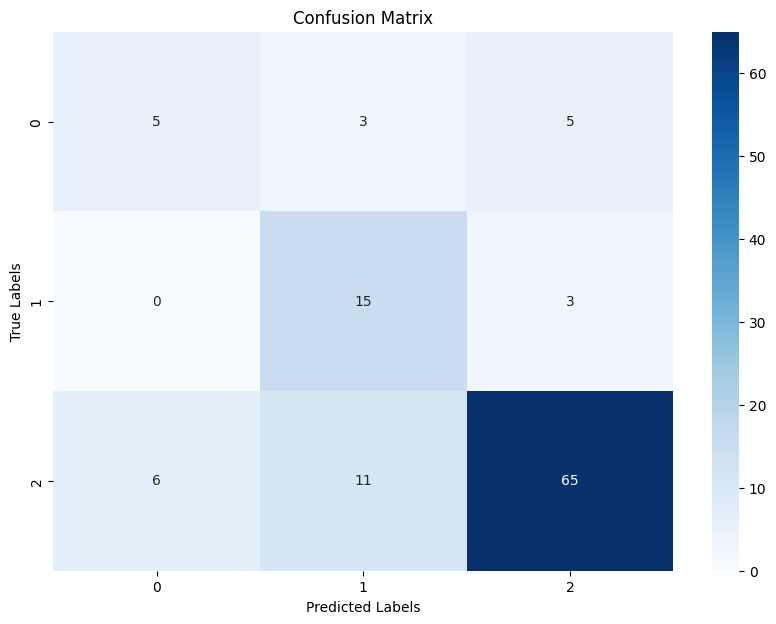

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming `model` is your trained model and `test_generator` is your data generator
# Make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print classification report
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.38      0.32        13
           1       0.48      0.72      0.58        18
           2       0.90      0.74      0.81        82

    accuracy                           0.70       113
   macro avg       0.55      0.62      0.57       113
weighted avg       0.76      0.70      0.72       113



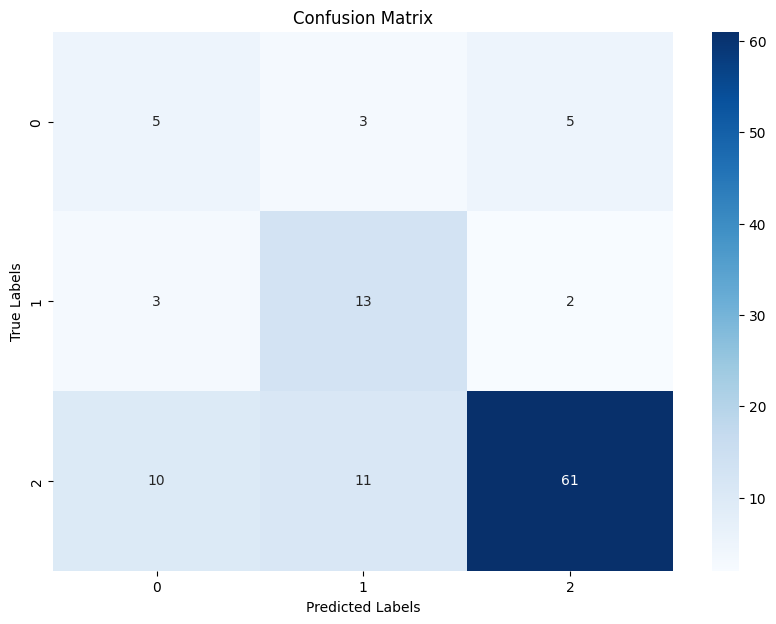

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom threshold for class 0
threshold_class_0 = 0.30

predictions = model.predict(val_generator, verbose=1)

# custom threshold
predicted_classes = []
for pred in predictions:
    if pred[0] > threshold_class_0:
        predicted_classes.append(0)
    else:
        predicted_classes.append(np.argmax(pred))


true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
